In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math

# Notebook description

Notebook to make preliminary plots of the HFSE abundaces measured in the CV chondrites. The notebook uses two seperate datasets collected in 2019 and 2022. All of the data was collected using the LA-ICP-MS at Rutgers University. The meteorites analyzed include:
- Vigps1B
- Vigps2B
- Leops2B
- Alps1
- Alps6
- Alps9

# Read in data

## Chondrite abundances

In [34]:
chondrite_abundances = pd.read_csv('Abunds_allnew_13jun2023.csv')
chondrite_abundances = chondrite_abundances.set_index('Element')
CI = chondrite_abundances.CI

## 2019 data

In [216]:
data_2019_sq = pd.read_csv('2019_LA_CVdata_SQ_input.csv')
data_2019_ca = pd.read_csv('2019_LA_CVdata_Ca_input.csv')
data_2019_si = pd.read_csv('2019_LA_CVdata_Si_input.csv')
data_2019_mg = pd.read_csv('2019_LA_CVdata_Mg_input.csv')

In [217]:
#removing negatives
data_2019 = ['data_2019_sq', 'data_2019_ca', 'data_2019_si', 'data_2019_mg']

for dataframe_name in data_2019:
    # Access the DataFrame by its name using eval()
    df = eval(dataframe_name)

    # Iterate over each column in the DataFrame
    for col in df.columns:
        # Check if the column has numeric values
        if pd.to_numeric(df[col], errors='coerce').dtype != object:
            # Replace negative numeric values with NaN
            df[col] = np.where(pd.to_numeric(df[col], errors='coerce') < 0, np.nan, df[col])

In [218]:
#adding Tm/Lu column to identify type II clasts

for dname in data_2019:
    locals()[dname] = locals()[dname].replace(0, np.nan) #replacing all zeros with nans
    locals()[dname]['Tm/Lu'] = locals()[dname].apply(lambda row: (row['Tm169_ppm_mean']/CI.Tm) / (row['Lu175_ppm_mean']/CI.Lu), axis=1) 

## 2022 data

In [219]:
data_2022_sq = pd.read_csv('2022_June_SQ_input2.csv')
data_2022_ca = pd.read_csv('2022_June_Ca_input2.csv')
data_2022_si = pd.read_csv('2022_June_Si_input2.csv')
data_2022_mg = pd.read_csv('2022_June_Mg_input2.csv')
data_2022_al = pd.read_csv('2022_June_Al_input2.csv')

In [220]:
#removing negatives
data_2022 = ['data_2022_sq', 'data_2022_ca', 'data_2022_si', 'data_2022_mg', 'data_2022_al']

for dataframe_name in data_2022:
    # Access the DataFrame by its name using eval()
    df = eval(dataframe_name)

    # Iterate over each column in the DataFrame
    for col in df.columns:
        # Check if the column has numeric values
        if pd.to_numeric(df[col], errors='coerce').dtype != object:
            # Replace negative numeric values with NaN
            df[col] = np.where(pd.to_numeric(df[col], errors='coerce') < 0, np.nan, df[col])

In [221]:
#adding Tm/Lu column to indentify type II clasts

for dname in data_2022:
    locals()[dname] = locals()[dname].replace(0, np.nan) #replacing all zeros with nans
    locals()[dname]['Tm/Lu'] = locals()[dname].apply(lambda row: (row['Tm169_ppm_mean']/CI.Tm) / (row['Lu175_ppm_mean']/CI.Lu), axis=1)

# Data finder function

In [39]:
def remove_outliers(data, threshold=3.5):
    # Uses median instead of mean so that extreme outliers don't affect calculation
    
    data_copy = data.copy()  # Make a copy of the data Series

    len_all = len(data_copy)
    len_nan = data_copy.isnull().sum()

    #if len_nan == (len_all - 1):
        #data_copy[data_copy > 300] = np.nan

    if (len_all != 0) and (len_all != len_nan) and (len_nan != (len_all - 1)):
        median = np.nanmedian(data_copy)
        mad = np.nanmedian(np.abs(data_copy - median))
        modified_z_scores = 0.6745 * (data_copy - median) / mad  # 0.6745 is a scaling factor for asymptotic consistency

        outliers = np.abs(modified_z_scores) > threshold
        data_copy[outliers] = np.nan

    return data_copy

In [40]:
def clip_nans(array):
    # Create an empty list to store the clipped array
    clipped_array = []

    # Iterate over each element in the array
    for element in array:
        # Check if the element is not a NaN
        if isinstance(element, str) or not np.isnan(element):
            # Add the element to the clipped array
            clipped_array.append(element)

    return clipped_array

In [41]:
def sub_df(pd_df, meteorite='all', obj='all', spots='all', phase='all', element='all', comp='all', dtype='mean', array='on', rmv_out='on', group='off'):
    
    #note:
    # - can only grab one object
    # - can only grab one phase
    
    if (meteorite != 'all'):
        df = pd_df[pd_df.Met_Name == meteorite]
        
        if obj!='all' and spots=='all':
            df = pd_df[(pd_df.Met_Name == meteorite) & (pd_df.Object == obj)]
            
        if obj!='all' and spots!='all':
            
            df = pd_df[(pd_df.Met_Name == meteorite) & (pd_df.Object == obj) & (pd_df.Spot_Num == spots[0])]
            if len(spots) > 1:
                for i in range(1, len(spots)):
                    df_spot = pd_df[(pd_df.Met_Name == meteorite) & (pd_df.Object == obj) & (pd_df.Spot_Num == spots[i])]
                    df = pd.concat([df, df_spot])
    
    if (meteorite=='all'): 
        df = pd_df
                    
    if (phase != 'all'):
        df = df[df.Phase==phase] 
        
    if (comp!='all'):
        comp_types = df.Component.unique()
        comp_types = clip_nans(comp_types)
        comp_grab = []
        
        for x in comp_types:
            if comp in x:
                comp_grab = np.append(comp_grab, x)
        
        if len(comp_grab) == 1:
            df = df[df.Component==comp_grab[0]]
        if len(comp_grab) == 2:
            df = df[(df.Component==comp_grab[0]) | (df.Component==comp_grab[1])]
        
    if (group=='II'):
        df = df[df['Tm/Lu']>1.5]
        
    if (element!='all'):
        col_names = df.columns.values
        col_grab  = ['LA_Name']
        if array == 'on':
            col_grab = []
        
        if element =='REE':
            element = ['La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu']
        
        if element == 'HFSE':
            element = ['Zr', 'Hf', 'Nb', 'Ta']
            
        if element == 'Zr/Hf':
            data_names = df[['LA_Name', 'Met_Name', 'Object', 'Spot_Num', 'Phase', 'Component', 'Tm/Lu']]
            
            if col_names[-1] == 'Zr/Hf':
                df = df.loc[:, 'Zr/Hf'].clip(lower=0).replace(0, np.nan) 
            
            if col_names[-1] != 'Zr/Hf':
                for x in col_names:

                    if ('Zr' in x) and ('ppm' in x) and (dtype in x):
                        col_grab = x
                    if ('Hf' in x) and ('ppm' in x) and (dtype in x):
                        col_grab = np.append(col_grab, x)

                df = df.loc[:, col_grab].clip(lower=0).replace(0, np.nan)  
                df['Zr/Hf'] = df.apply(lambda row: row[-2] / row[-1], axis=1)
            
            df = data_names.merge(df, left_index=True, right_index=True)
            
            if array=='on':
                df = df['Zr/Hf']
            
        if element == 'Nb/Ta':
            data_names = df[['LA_Name', 'Met_Name', 'Object', 'Spot_Num', 'Phase', 'Component', 'Tm/Lu']]
            
            if col_names[-1] == 'Nb/Ta':
                df = df.loc[:, 'Nb/Ta'].clip(lower=0).replace(0, np.nan)
            
            if col_names[-1] != 'Nb/Ta':
                for x in col_names:
                    if ('Nb' in x) and ('ppm' in x) and (dtype in x):
                        nb = x
                    if ('Ta' in x) and ('ppm' in x) and (dtype in x):
                        ta = x

                df = df.loc[:, [nb, ta]].clip(lower=0).replace(0, np.nan)  # Using .loc to assign values and clipping negative values to NaN
                df['Nb/Ta'] = df.apply(lambda row: row[-2] / row[-1], axis=1)
            
            df = data_names.merge(df, left_index=True, right_index=True)
            
            
            if array=='on':
                df = df['Nb/Ta']
        
        if element == 'Tm/Lu':
            data_names = df['LA_Name']
            df = df['Tm/Lu']
            df = pd.concat([data_names, df], axis=1)
            #df = df.set_index(['LA_Name'])
            
            if array=='on':
                    df = df['Tm/Lu']   
        
        if element != 'Zr/Hf' and element != 'Nb/Ta' and element != 'Tm/Lu':
            
            for i in range(0, len(element)):
                for x in col_names:
                    if (element[i] in x) and ('ppm' in x) and (dtype in x):
                        col_grab = np.append(col_grab, x)
            
                    
                 
                    
            df = df[col_grab]
            if array == 'on':
                df[df<0]= np.nan
                
        
        if rmv_out == 'on' and array == 'on':
            df = remove_outliers(df)
            
        if rmv_out == 'on' and array == 'off':
            last_col = df.iloc[:, -1]
            df.iloc[:, -1] = remove_outliers(last_col)
        
        
    return df

In [42]:
x = sub_df(data_2022_sq, meteorite='Alps6', element='Zr/Hf', array='off')
x

,LA_Name,Met_Name,Object,Spot_Num,Phase,Component,Tm/Lu,Zr90_ppm_mean,Hf178_ppm_mean,Zr/Hf
223,Alps6_c13_1,Alps6,c13,1,gls,chondrule,0.995869,28.399426,0.662429,42.871671
224,Alps6_c13_2,Alps6,c13,2,opx,chondrule,0.522227,1.315158,0.072417,18.160887
225,Alps6_c13_3,Alps6,c13,3,gls,chondrule,1.006418,44.611548,1.135188,39.298831
226,Alps6_c13_4,Alps6,c13,4,olv,chondrule,0.554651,0.222752,0.018806,11.844546
227,Alps6_c13_8,Alps6,c13,8,gls,chondrule,1.092259,51.348110,1.252276,41.003821
...,...,...,...,...,...,...,...,...,...,...
392,Alps6_c24_2,Alps6,c24,2,olv,chondrule,0.714608,0.176737,0.003972,44.492910
393,Alps6_c24_3,Alps6,c24,3,olv,chondrule,0.779960,0.368087,0.012099,30.424042
394,Alps6_c32_5,Alps6,c32,5,olv,chondrule,0.414227,0.995553,0.027111,36.720837
395,Alps6_c40_1,Alps6,c40,1,olv,chondrule,0.680188,0.141866,0.002546,55.718281


# gathering subset of data for plotting

Internal standardization:
- olv = mg
- aoa = si
- cpx = si
- gls = ca
- opx = mg
- cai = ca
- matrix = ca

In [222]:
phases  = data_2019_sq.Phase.unique()[6:]
int_std = ['mg', 'si', 'si', 'ca', 'mg', 'ca', 'ca']

In [223]:
zrhf = pd.DataFrame()
nbta = pd.DataFrame()

for i in range(0, len(phases)):
    
    d2019 = 'data_2019_' + int_std[i] #grabbing 2019 dataframes
    d2022 = 'data_2022_' + int_std[i] #grabbing 2022 dataframes
    
    zrhf = pd.concat([zrhf, 
                      sub_df(globals()[d2019], element='Zr/Hf', array='off', phase=phases[i], rmv_out='off'),
                     sub_df(globals()[d2022], element='Zr/Hf', array='off', phase=phases[i], rmv_out='off')])
    
    nbta = pd.concat([nbta, 
                      sub_df(globals()[d2019], element='Nb/Ta', array='off', phase=phases[i], rmv_out='off'),
                     sub_df(globals()[d2022], element='Nb/Ta', array='off', phase=phases[i], rmv_out='off')])
        
zrhf['Zr/Hf'] = remove_outliers(zrhf['Zr/Hf'])
nbta['Nb/Ta'] = remove_outliers(nbta['Nb/Ta'])

# plotting all the data with improved function (color=phase, marker=meteorite)

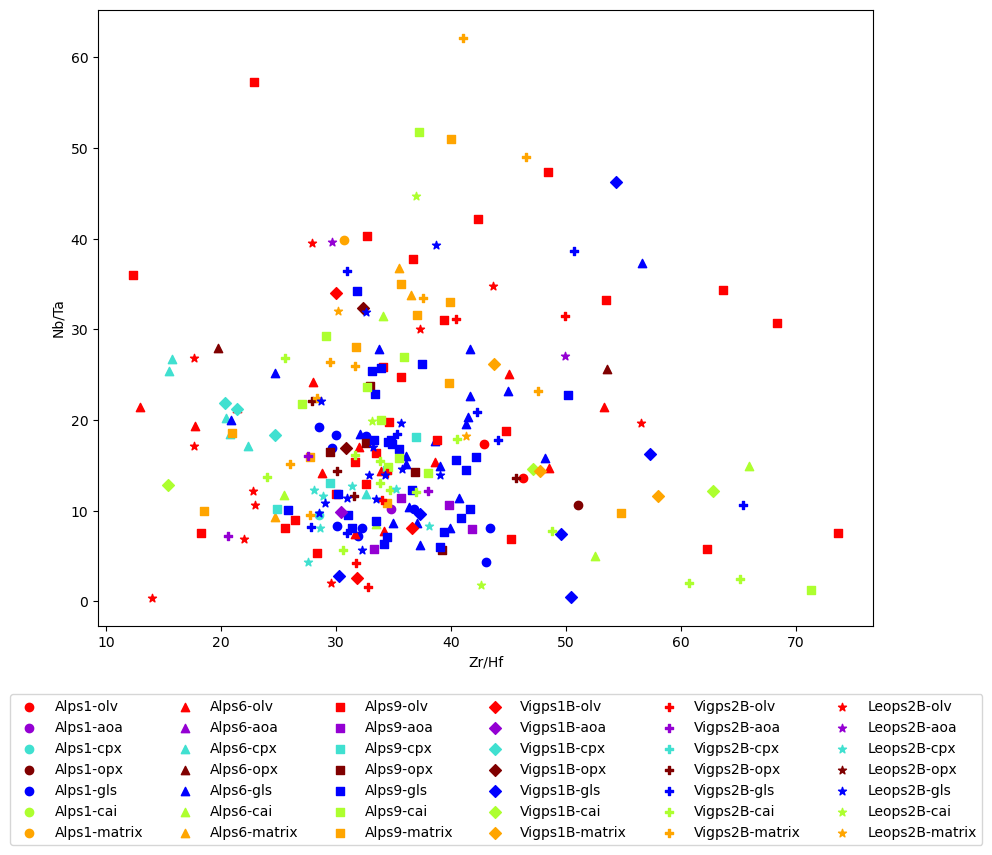

In [182]:
#plotting

#what I want to look at:
meteorites = ['Alps1', 'Alps6', 'Alps9', 'Vigps1B', 'Vigps2B', 'Leops2B']
phases     = ['olv', 'aoa', 'cpx', 'opx', 'gls', 'cai', 'matrix']

#arrays for plotting
met_shape = ['o', '^', 's', 'D', 'P', '*']
phs_color = ['red', 'darkviolet', 'turquoise', 'maroon', 'blue', 'greenyellow', 'orange']

#setting up plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlabel('Zr/Hf')
ax.set_ylabel('Nb/Ta')


#plotting loop
met_i = 0
for met in meteorites:
    phs_i = 0
    for phs in phases:
       
        #grabbing data
        zrhf_plot = sub_df(zrhf, meteorite=met, phase=phs, element='Zr/Hf', rmv_out='off')
        nbta_plot = sub_df(nbta, meteorite=met, phase=phs, element='Nb/Ta', rmv_out='off')
        
        #plotting
        ax.scatter(zrhf_plot, nbta_plot, color=phs_color[phs_i], marker=met_shape[met_i], label=met+'-'+phs, )
                           
        phs_i+=1
    met_i+=1
    
ax.legend(bbox_to_anchor=(1.15, -0.1), ncols=6);


/tmp/ipykernel_338/1206251490.py:27: RuntimeWarning: Mean of empty slice
  zrhf_plot = np.nanmean(sub_df(zrhf, meteorite=met, phase=phs, element='Zr/Hf', rmv_out='off'))
/tmp/ipykernel_338/1206251490.py:28: RuntimeWarning: Mean of empty slice
  nbta_plot = np.nanmean(sub_df(nbta, meteorite=met, phase=phs, element='Nb/Ta', rmv_out='off'))
/tmp/ipykernel_338/1206251490.py:27: RuntimeWarning: Mean of empty slice
  zrhf_plot = np.nanmean(sub_df(zrhf, meteorite=met, phase=phs, element='Zr/Hf', rmv_out='off'))
/tmp/ipykernel_338/1206251490.py:28: RuntimeWarning: Mean of empty slice
  nbta_plot = np.nanmean(sub_df(nbta, meteorite=met, phase=phs, element='Nb/Ta', rmv_out='off'))
/tmp/ipykernel_338/1206251490.py:27: RuntimeWarning: Mean of empty slice
  zrhf_plot = np.nanmean(sub_df(zrhf, meteorite=met, phase=phs, element='Zr/Hf', rmv_out='off'))
/tmp/ipykernel_338/1206251490.py:28: RuntimeWarning: Mean of empty slice
  nbta_plot = np.nanmean(sub_df(nbta, meteorite=met, phase=phs, element='Nb/T

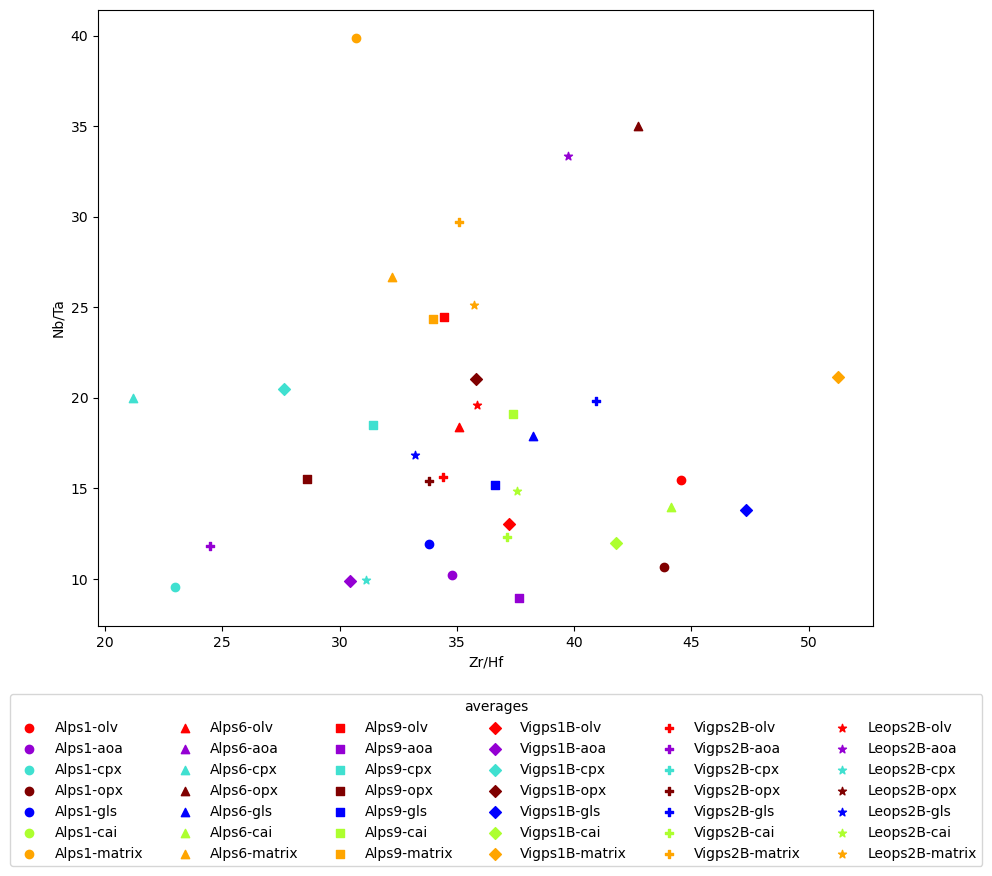

In [183]:
#plotting

#what I want to look at:
meteorites = ['Alps1', 'Alps6', 'Alps9', 'Vigps1B', 'Vigps2B', 'Leops2B']
phases     = ['olv', 'aoa', 'cpx', 'opx', 'gls', 'cai', 'matrix']

#arrays for plotting
met_shape = ['o', '^', 's', 'D', 'P', '*']
phs_color = ['red', 'darkviolet', 'turquoise', 'maroon', 'blue', 'greenyellow', 'orange']

#setting up plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlabel('Zr/Hf')
ax.set_ylabel('Nb/Ta')


#zrhf = pd.concat([sub_df(data_2019, element='Zr/Hf', array='off'), sub_df(data_2022, element='Zr/Hf', array='off')])
#nbta = pd.concat([sub_df(data_2019, element='Nb/Ta', array='off'), sub_df(data_2022, element='Nb/Ta', array='off')])

#plotting loop
met_i = 0
for met in meteorites:
    phs_i = 0
    for phs in phases:
       
        #grabbing data
        zrhf_plot = np.nanmean(sub_df(zrhf, meteorite=met, phase=phs, element='Zr/Hf', rmv_out='off'))
        nbta_plot = np.nanmean(sub_df(nbta, meteorite=met, phase=phs, element='Nb/Ta', rmv_out='off'))
        
        #plotting
        ax.scatter(zrhf_plot, nbta_plot, color=phs_color[phs_i], marker=met_shape[met_i], label=met+'-'+phs)
                           
        phs_i+=1
    met_i+=1
    
ax.legend(bbox_to_anchor=(1.15, -0.1), ncols=6, title='averages');


# plot (color=component, marker=meteorite)

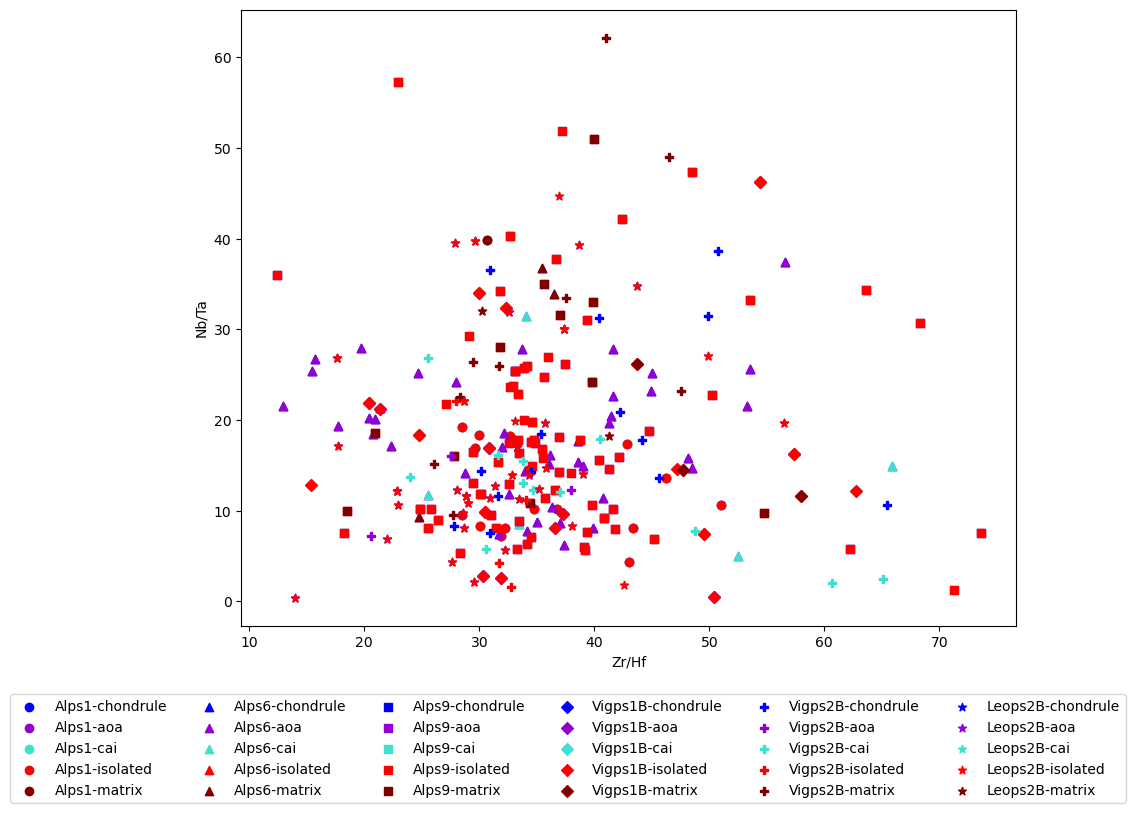

In [184]:
#plotting

#what I want to look at:
meteorites = ['Alps1', 'Alps6', 'Alps9', 'Vigps1B', 'Vigps2B', 'Leops2B']
components = ['chondrule', 'aoa', 'cai', 'isolated', 'matrix']

#arrays for plotting
met_shape = ['o', '^', 's', 'D', 'P', '*']
cmp_color = ['blue', 'darkviolet', 'turquoise', 'red', 'maroon']

#setting up plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlabel('Zr/Hf')
ax.set_ylabel('Nb/Ta')

#plotting loop
met_i = 0
for met in meteorites:
    cmp_i = 0
    for cmp in components:
        
        #grabbing data
        zrhf_plot = sub_df(zrhf, meteorite=met, comp=cmp, element='Zr/Hf', rmv_out='off')
        nbta_plot = sub_df(nbta, meteorite=met, comp=cmp, element='Nb/Ta', rmv_out='off')
        
        #plotting
        ax.scatter(zrhf_plot, nbta_plot, color=cmp_color[cmp_i], marker=met_shape[met_i], label=met+'-'+cmp)
        
        cmp_i+=1
    met_i+=1

ax.legend(bbox_to_anchor=(1.15, -0.1), ncols=6);

# plot (color=meteorite)

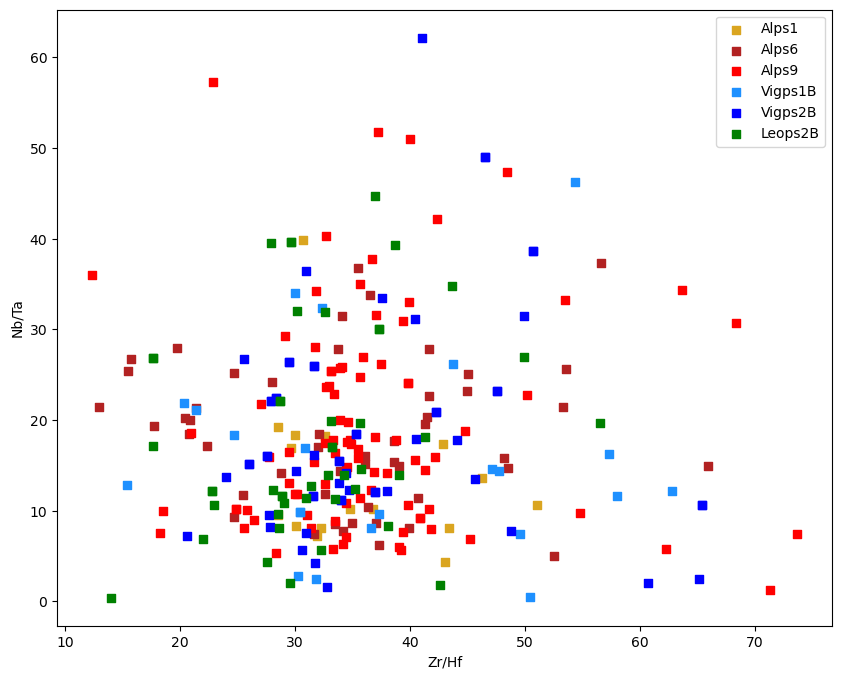

In [185]:
#what I want to look at:
meteorites = ['Alps1', 'Alps6', 'Alps9', 'Vigps1B', 'Vigps2B', 'Leops2B']

#arrays for plotting
met_color = ['goldenrod', 'firebrick', 'red', 'dodgerblue', 'blue', 'green']

#setting up plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlabel('Zr/Hf')
ax.set_ylabel('Nb/Ta')

#plotting loop
met_i = 0
for met in meteorites:
    
    #grabbing data
    zrhf_plot = sub_df(zrhf, meteorite=met, element='Zr/Hf', rmv_out='off')
    nbta_plot = sub_df(nbta, meteorite=met, element='Nb/Ta', rmv_out='off')

    #plotting
    ax.scatter(zrhf_plot, nbta_plot, color=met_color[met_i], marker='s', label=met)
        
    met_i+=1

ax.legend();

# plot (average ratios by phase & by component)

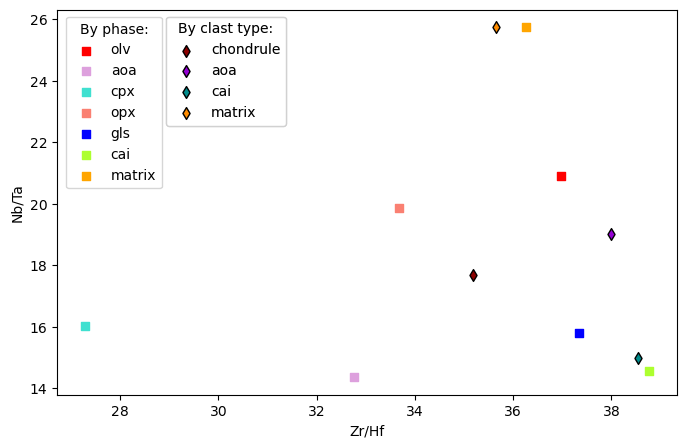

In [186]:
#plotting

#what I want to look at:
components = ['chondrule', 'aoa', 'cai', 'isolated', 'matrix']
clasts = ['chondrule', 'aoa', 'cai', 'matrix']
phases = ['olv', 'aoa', 'cpx', 'opx', 'gls', 'cai', 'matrix']

#arrays for plotting
clst_color= ['darkred', 'darkviolet', 'darkcyan', 'darkorange']
phs_color = ['red', 'plum', 'turquoise', 'salmon', 'blue', 'greenyellow', 'orange']

#setting up plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_xlabel('Zr/Hf')
ax.set_ylabel('Nb/Ta')

#plotting loop for phases
phs_handles = []
phs_i = 0
for phs in phases:
    #grabbing data
    zrhf_plot = sub_df(zrhf, phase=phs, element='Zr/Hf', rmv_out='off')
    nbta_plot = sub_df(nbta, phase=phs, element='Nb/Ta', rmv_out='off')

    #calculating new averages
    zrhf_mean  = np.nanmean(zrhf_plot)
    nbta_mean  = np.nanmean(nbta_plot)
    
    #plotting
    phs_plot = ax.scatter(zrhf_mean, nbta_mean,  color=phs_color[phs_i], marker='s', label=phs)
    phs_handles.append(phs_plot)
    phs_i+=1
    
    
# Creating the legend for phases
legend1 = ax.legend(handles=phs_handles, title='By phase:', bbox_to_anchor=(0.18, 1))
ax.add_artist(legend1)

#plotting loop for clasts
clst_handles = []

clst_i = 0
for clst in clasts:

    #grabbing data
    zrhf_plot = sub_df(zrhf, comp=clst, element='Zr/Hf', rmv_out='off')
    nbta_plot = sub_df(nbta, comp=clst, element='Nb/Ta', rmv_out='off')

    #calculating new averages
    zrhf_mean  = np.nanmean(zrhf_plot)
    nbta_mean  = np.nanmean(nbta_plot)
    
    #plotting
    clst_plot = ax.scatter(zrhf_mean, nbta_mean, color=clst_color[clst_i], edgecolor='k', marker='d', label=clst)
    clst_handles.append(clst_plot)
    clst_i+=1
    
# Creating the legend for clasts
legend2 = ax.legend(handles=clst_handles, title='By clast type:', bbox_to_anchor=(0.38, 1))
ax.add_artist(legend2);

# plot (highlighting type II clasts)

In [224]:
#type II data
zrhf_II = sub_df(zrhf, element='Zr/Hf', group='II')
nbta_II = sub_df(nbta, element='Nb/Ta', group='II')

#non type II data
zrhf_non = sub_df(zrhf, element='Zr/Hf', array='on')
nbta_non = sub_df(nbta, element='Nb/Ta', array='on')

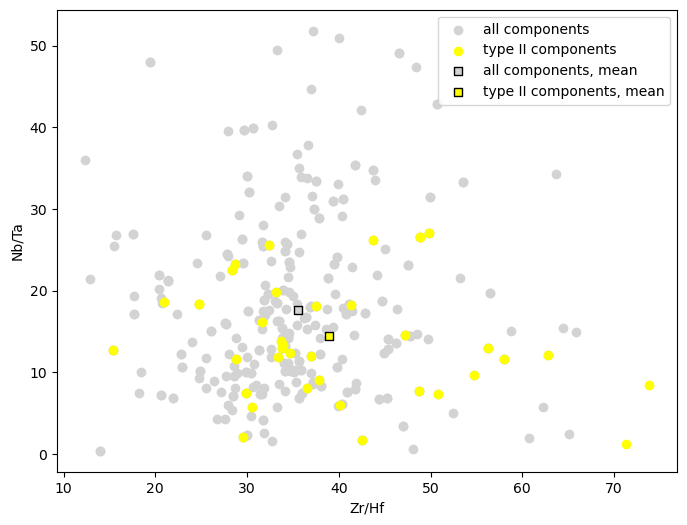

In [225]:
#setting up figure
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel('Zr/Hf')
ax.set_ylabel('Nb/Ta')

#plotting
ax.scatter(zrhf_non, nbta_non, color='lightgrey', zorder=0, label='all components')
ax.scatter(zrhf_II, nbta_II, color='yellow', zorder=0, label='type II components')

ax.scatter(np.nanmean(zrhf_non), np.nanmean(nbta_non), color='lightgrey', zorder=1, label='all components, mean', marker='s', edgecolor='k')
ax.scatter(np.nanmean(zrhf_II), np.nanmean(nbta_II), color='yellow', zorder=1, label='type II components, mean', marker='s', edgecolor='k')

ax.legend();

In [226]:
#type II data
zrhf_II = sub_df(zrhf, element='Zr/Hf', comp='cai', group='II')
nbta_II = sub_df(nbta, element='Nb/Ta', comp='cai', group='II')

#non type II data
zrhf_non = sub_df(zrhf, element='Zr/Hf', comp='cai', array='on')
nbta_non = sub_df(nbta, element='Nb/Ta', comp='cai', array='on')

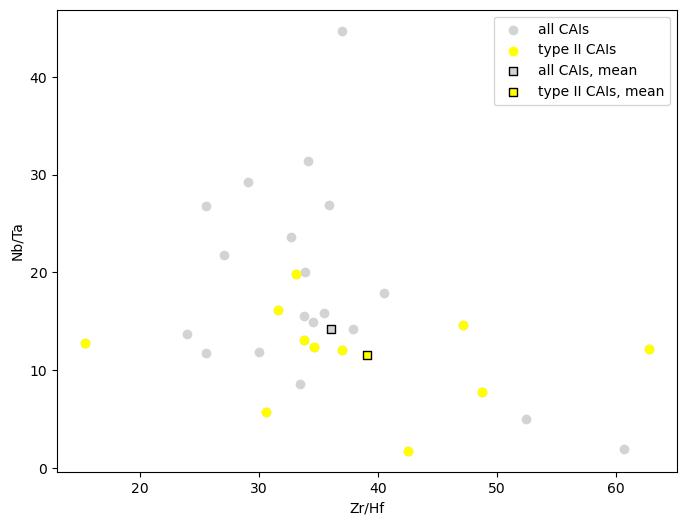

In [227]:
#setting up figure
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel('Zr/Hf')
ax.set_ylabel('Nb/Ta')
#ax.set_xlim([-5, 150])
#ax.set_ylim([-5, 150])

#plotting
ax.scatter(zrhf_non, nbta_non, color='lightgrey', zorder=0, label='all CAIs')
ax.scatter(zrhf_II, nbta_II, color='yellow', zorder=1, label='type II CAIs')

ax.scatter(np.nanmean(zrhf_non), np.nanmean(nbta_non), color='lightgrey', zorder=1, label='all CAIs, mean', marker='s', edgecolor='k')
ax.scatter(np.nanmean(zrhf_II), np.nanmean(nbta_II), color='yellow', zorder=1, label='type II CAIs, mean', marker='s', edgecolor='k')

ax.legend();

# to double check group II identification

In [228]:
zrhf_II = sub_df(zrhf, element='Zr/Hf', group='II', array='off')
nbta_II = sub_df(nbta, element='Nb/Ta', group='II', array='off')

In [229]:
zrhf_II.sort_values('LA_Name')

,LA_Name,Met_Name,Object,Spot_Num,Phase,Component,Tm/Lu,Zr/Hf
293,Alps6_c33_4,Alps6,c33,4.0,cai,cai,1.614331,53.238194
144,Alps9-c3_5,Alps9,c3,5.0,cai,cai,3.831007,NaN
31,Alps9-c3_6,Alps9,c3,6.0,cpx,cai,2.307448,NaN
216,Alps9_c15_4,Alps9,c15,4.0,olv,chondrule,1.511274,NaN
158,Alps9_c22_2,Alps9,c22,2.0,gls,chondrule,1.781795,37.550070
...,...,...,...,...,...,...,...,...
114,Vigps2B_c2_11,Vigps2B,c2,11.0,cai,cai,27.675196,NaN
20,Vigps2B_c2_13,Vigps2B,c2,13.0,cai,cai,10.487930,NaN
131,Vigps2B_c2_14,Vigps2B,c2,14.0,cai,cai,10.377700,NaN
133,Vigps2B_c5_5,Vigps2B,c5,5.0,cai,cai,5.068183,30.564854
